<a href="https://colab.research.google.com/github/saba-ramezani/Medical_Symptom_to_Disease_Prediction_NLP/blob/main/Medical_Symptom_to_Disease_Prediction_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Symptom to Disease Prediction NLP

## 1. Install dependencies

In [14]:
# !pip install scikit-learn pandas numpy seaborn matplotlib shap umap-learn transformers torch --quiet
# !pip install transformers datasets evaluate --quiet
# !pip install spacy --quiet
# !python -m spacy download en_core_web_sm --quiet


## 2. Load Symptoms2Disease kaggle dataset

In [15]:
import pandas as pd

# Load the dataset
url = "/content/drive/MyDrive/MedicalProjects/NLP/Disease_Prediction/Dataset/Symptom2Disease.csv"
df = pd.read_csv(url)

# Inspect the dataset
df = df[['label', 'text']]
df.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [16]:
df.shape

(1200, 2)

## 3. Data analysis & visualization

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-500971096.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")


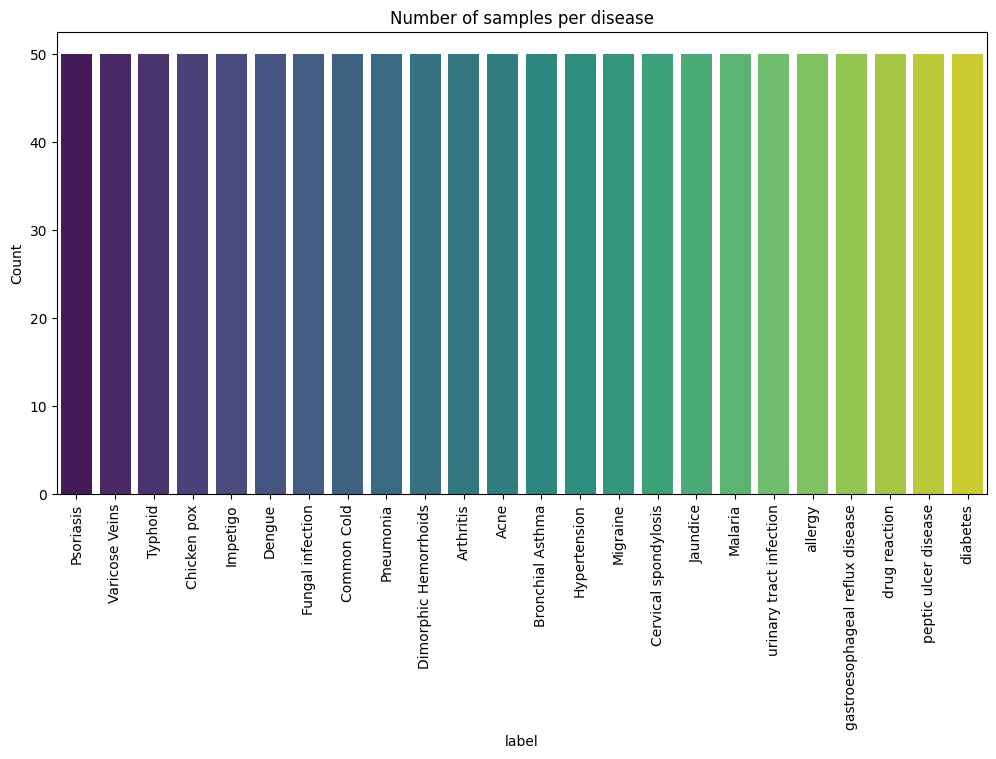

24

In [18]:
# Number of diseases
disease_counts = df['label'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Number of samples per disease")
plt.ylabel("Count")
plt.show()

len(disease_counts)

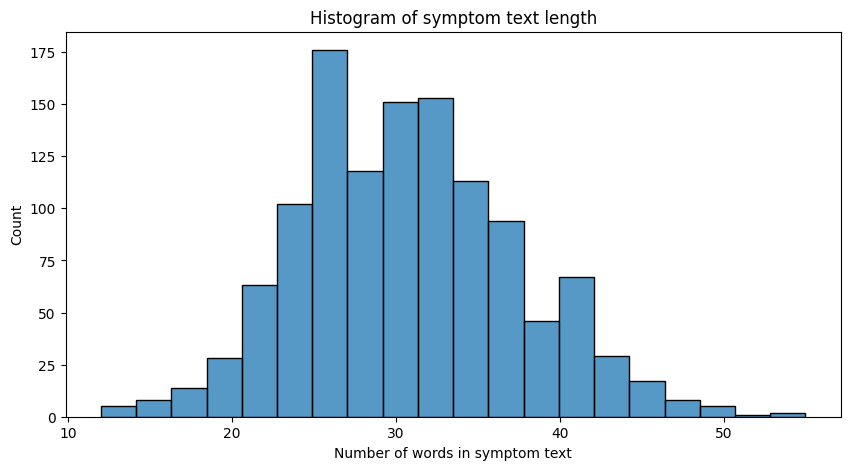

In [19]:
# Text length analysis
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,5))
sns.histplot(df['text_len'], bins=20)
plt.title("Histogram of symptom text length")
plt.xlabel("Number of words in symptom text")
plt.show()

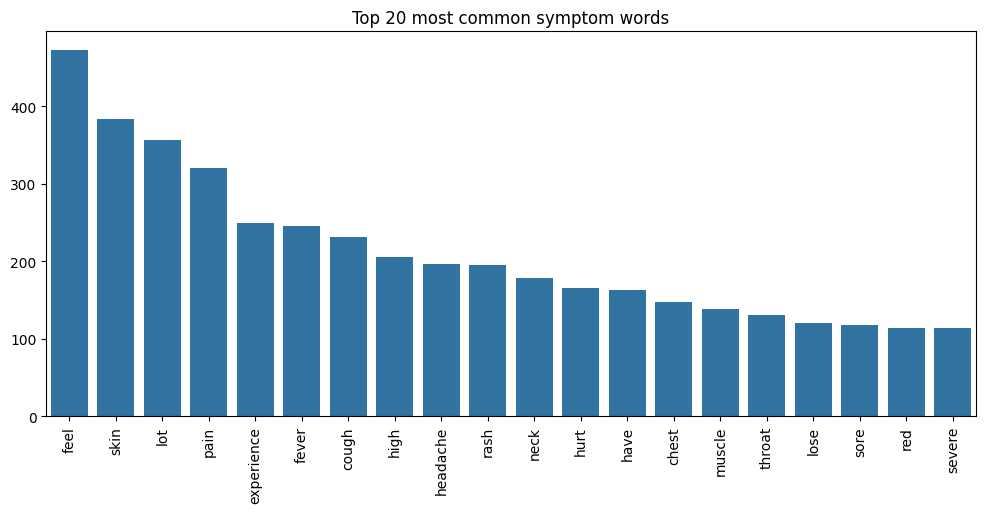

In [27]:
# Example: most common words
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")

all_tokens = [token.lemma_.lower() for doc in nlp.pipe(df['text'], batch_size=50) for token in doc if token.is_alpha and not token.is_stop]
counter = Counter(all_tokens)
most_common_words = counter.most_common(20)
plt.figure(figsize=(12,5))
sns.barplot(x=[w[0] for w in most_common_words], y=[w[1] for w in most_common_words])
plt.title("Top 20 most common symptom words")
plt.xticks(rotation=90)
plt.show()
